# 电商多模态图文检索——Chinese-CLIP baseline全流程示例

<p align="center">
    <br>
    <img src="https://modelscope.cn/api/v1/models/damo/multi-modal_clip-vit-base-patch16_zh/repo?Revision=master&FilePath=resources/Chinese_CLIP_logo_tp_path.svg&View=true" width="300" />
    <br>
<p>

Chinese-CLIP是OpenAI CLIP模型的中文版本，基于OpenAI CLIP的视觉侧参数，继续使用大规模中文原生图文数据，进行如下图所示的两阶段预训练（\~2亿中文图文对）。旨在帮助用户快速实现中文领域的图文特征&相似度计算、跨模态检索、零样本图片分类等任务，在[电商多模态图文检索挑战赛](https://tianchi.aliyun.com/competition/entrance/532031/introduction)（即MUGE检索数据集）效果显著。我们这里提供一个基于base规模的baseline全流程实现，方便同学们更简单上手，可以在验证集取得\~75左右的Mean Recall分数。如果大家想要深入了解和改进模型代码，提高比赛分数，欢迎在Github开源repo了解更多细节\~

<p align="center">
    <br>
    <img src="https://modelscope.cn/api/v1/models/damo/multi-modal_clip-vit-base-patch16_zh/repo?Revision=master&FilePath=resources/chinese_clip_pretrain.png&View=true" width="300" />
    <br>
<p>

**代码Github开源链接（欢迎star \& fork🔥🔥）:** https://github.com/OFA-Sys/Chinese-CLIP 
    
**技术报告:** https://arxiv.org/abs/2211.01335

**电商多模态图文检索挑战赛主页**: https://tianchi.aliyun.com/competition/entrance/532031/introduction

## 说明：

1. 基于此notebook，可以轻松实现利用**Chinese-CLIP**图文预训练双塔表征模型，在电商多模态图文检索挑战赛完成finetune及验证集/测试集预测
2. 由于对比学习对于训练batch大小有一定的基本要求，此notebook运行至少**需要8GB显存**，请大家在GPU显存满足此要求的运行环境下下载并运行此notebook（[下载链接](https://github.com/OFA-Sys/Chinese-CLIP/blob/master/Chinese-CLIP-on-MUGE-Retrieval.ipynb)），尝试baseline流程。目前天池实验室Notebook环境暂不支持使用这个规模的显存，达摩院[ModelScope平台](https://modelscope.cn/models/damo/multi-modal_clip-vit-base-patch16_zh/summary)提供了一定的GPU机时（进入链接后右上角"在Notebook打开"），资源紧张的同学可以考虑利用
3. 请保证环境Pytorch版本至少在1.8.0及以上
4. Notebook中的流程较为简单，主要方便参赛选手上手跑通一个不错的base规模（视觉侧ViT-B/16，文本侧Roberta-base）baseline。如果要继续调优或改进模型，建议进一步详细参考github开源源码（尤其是[readme跨模态检索部分的文档](https://github.com/OFA-Sys/Chinese-CLIP#跨模态检索)）和Chinese-CLIP技术报告

## 准备工作
### 1. Clone代码库并准备数据目录

In [4]:
# clone Chinese-CLIP代码库到用户目录(如果因网络问题卡在git clone这步，请interrupt该步并重试几次)：
!git clone https://github.com/OFA-Sys/Chinese-CLIP.git

# 创建一个datapath文件夹，用于存放数据集和Chinese-CLIP参数
!mkdir -p datapath
!mkdir -p datapath/pretrained_weights # 存放预训练参数
!mkdir -p datapath/datasets # 存放数据集
!mkdir -p datapath/experiments # 存放finetune参数和日志

!tree .

Cloning into 'Chinese-CLIP'...
remote: Enumerating objects: 990, done.
remote: Counting objects: 100% (364/364), done.
remote: Compressing objects: 100% (131/131), done.
remote: Total 990 (delta 328), reused 233 (delta 233), pack-reused 626
Receiving objects: 100% (990/990), 402.11 KiB | 593.00 KiB/s, done.
Resolving deltas: 100% (633/633), done.
Updating files: 100% (54/54), done.
.
├── Chinese-CLIP
│   ├── assets
│   │   └── Chinese_CLIP_logo_tp_path.svg
│   ├── cn_clip
│   │   ├── clip
│   │   │   ├── bert_tokenizer.py
│   │   │   ├── configuration_bert.py
│   │   │   ├── __init__.py
│   │   │   ├── model_configs
│   │   │   │   ├── RBT3-chinese.json
│   │   │   │   ├── RN50.json
│   │   │   │   ├── RoBERTa-wwm-ext-base-chinese.json
│   │   │   │   ├── RoBERTa-wwm-ext-large-chinese.json
│   │   │   │   ├── ViT-B-16.json
│   │   │   │   ├── ViT-B-32.json
│   │   │   │   ├── ViT-H-14.json
│   │   │   │   ├── ViT-L-14-336.json
│   │   │   │   └── ViT-L-14.json
│   │   │   ├── modeling_

### 2. 安装Chinese-CLIP相关依赖

In [5]:
# 安装Chinese-CLIP依赖包
!pip install -r Chinese-CLIP/requirements.txt

Looking in indexes: https://mirrors.aliyun.com/pypi/simple/


In [6]:
# 查看当前kernel下已安装的包  list packages
!pip list --format=columns

Package                      Version
---------------------------- ------------
absl-py                      0.15.0
aiohttp                      3.8.1
aiosignal                    1.2.0
alibabacloud-credentials     0.2.0
alibabacloud-endpoint-util   0.0.3
alibabacloud-gateway-spi     0.0.1
alibabacloud-openapi-util    0.1.6
alibabacloud-pai-dlc20201203 1.0.0
alibabacloud-tea             0.2.9
alibabacloud-tea-openapi     0.3.3
alibabacloud-tea-util        0.3.5
alibabacloud-tea-xml         0.0.2
alipai                       0.1.7
aliyun-log-python-sdk        0.7.9
aliyun-python-sdk-core       2.13.36
aliyun-python-sdk-kms        2.15.0
aliyun-python-sdk-sts        3.1.0
apache-beam                  2.15.0
apache-flink                 1.10.1
argcomplete                  2.0.0
argon2-cffi                  21.3.0
argon2-cffi-bindings         21.2.0
asn1crypto                   0.24.0
astor                        0.8.1
astroid                      2.11.5
astunparse                   1.6.3
a

### 3. 下载Chinese-CLIP预训练参数

In [7]:
# 下载base规模Chinese-CLIP预训练参数：
!wget https://www.modelscope.cn/models/AI-ModelScope/chinese-clip-vit-base-patch16/resolve/master/clip_cn_vit-b-16.pt
!mv clip_cn_vit-b-16.pt datapath/pretrained_weights/

### 4. 预处理数据

In [ ]:
# 详细的预处理数据流程，请参见github readme: https://github.com/OFA-Sys/Chinese-CLIP#数据集格式预处理
# 我们这里方便起见，直接下载已经预处理好（处理成LMDB格式）的电商检索数据集
!wget https://huggingface.co/datasets/OFA-Sys/chinese-clip-eval/resolve/main/MUGE.zip
!mv MUGE.zip datapath/datasets/
%cd datapath/datasets/
!unzip MUGE.zip
%cd ../..
!tree datapath/

--2023-01-13 15:41:28--  https://huggingface.co/datasets/OFA-Sys/chinese-clip-eval/resolve/main/MUGE.zip
...
HTTP request sent, awaiting response... 200 OK
Length: 2166554702 (2.0G) [application/zip]
Saving to: ‘MUGE.zip’

MUGE.zip            100%[===================>]   2.02G  26.7MB/s    in 89s     

2023-01-13 15:42:58 (23.1 MB/s) - ‘MUGE.zip’ saved [2166554702/2166554702]

/mnt/workspace/tianchi/datapath/datasets
Archive:  MUGE.zip
   creating: MUGE/
   creating: MUGE/lmdb/
   creating: MUGE/lmdb/train/
   creating: MUGE/lmdb/train/imgs/
  inflating: MUGE/lmdb/train/imgs/data.mdb  
  inflating: MUGE/lmdb/train/imgs/lock.mdb  
   creating: MUGE/lmdb/train/pairs/
  inflating: MUGE/lmdb/train/pairs/data.mdb  
  inflating: MUGE/lmdb/train/pairs/lock.mdb  
   creating: MUGE/lmdb/valid/
   creating: MUGE/lmdb/valid/imgs/
  inflating: MUGE/lmdb/valid/imgs/data.mdb  
  inflating: MUGE/lmdb/valid/imgs/lock.mdb  
   creating: MUGE/lmdb/valid/pairs/
  inflating: MUGE/lmdb/valid/pairs/data.mdb

{"text_id": 248816, "text": "圣诞 抱枕", "image_ids": [1006938, 561749, 936929, 286314, 141999, 183846]}


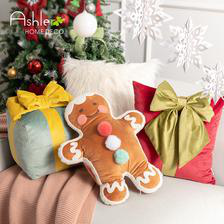

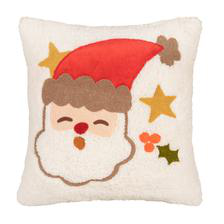

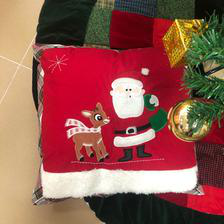

In [9]:
# 查看数据样例
!head -n 1 datapath/datasets/MUGE/valid_texts.jsonl # 验证集第一条样本

import lmdb
import base64
from io import BytesIO
from PIL import Image

image_ids = [286314, 141999, 183846]

lmdb_imgs = "datapath/datasets/MUGE/lmdb/valid/imgs"
env_imgs = lmdb.open(lmdb_imgs, readonly=True, create=False, lock=False, readahead=False, meminit=False)
txn_imgs = env_imgs.begin(buffers=True)
for image_id in image_ids:
    image_b64 = txn_imgs.get("{}".format(image_id).encode('utf-8')).tobytes()
    img = Image.open(BytesIO(base64.urlsafe_b64decode(image_b64)))
    img.show()

## 运行finetune训练

In [10]:
# 进入代码工作区目录
%cd Chinese-CLIP/

/mnt/workspace/tianchi/Chinese-CLIP


下面我们开始运行finetune，说明如下：
+ 下面的代码改编自代码库中的shell运行脚本: Chinese-CLIP/run_scripts/muge_finetune_vit-b-16_rbt-base.sh
+ **详细的finetune各配置项，请参见: https://github.com/OFA-Sys/Chinese-CLIP#模型finetune**
+ 执行训练的python代码，请参见: Chinese-CLIP/cn_clip/training/main.py
+ 模型实现的python代码，请参见: Chinese-CLIP/cn_clip/clip/model.py 以及比赛官方学习视频对于模型实现的介绍
+ 按照如下的超参进行finetune，要求机器需要至少达到8G显存，finetune时间大约需要40min左右（V100上测试）
+ **请注意finetune中间给出的验证集准确率，是验证集batch内部，图文对之间的Recall@1正确率，与比赛指标要求的从整个验证集/测试集图片池召回的Recall@1并不是同一个指标。这里仅用于观察训练趋势，如果要评测模型效果，请完整运行下文的特征提取、KNN召回和计算Recall流程**
+ 对比学习的训练收敛和稳定性和总batch size相关。如您使用较小的batch size（比如我们这里的48 per-GPU * 1 GPU），建议使用较小的学习率（如我们这里的3e-6）。我们推荐使用更多的GPU和更大的batch size以取得更好的效果。
+ 训练完成后如果输出打印EOFError，无视即可

In [37]:
# 准备finetune相关配置，详见https://github.com/OFA-Sys/Chinese-CLIP#模型finetune
# 指定机器数 & 卡数
GPUS_PER_NODE=1 # 卡数
WORKER_CNT=1 # 机器数
MASTER_ADDR="localhost"
MASTER_PORT=8514 # 同台机器同时起多个任务，请分别分配不同的端口号
RANK=0 

# 刚刚创建过的目录，存放了预训练参数和预处理好的数据集
DATAPATH="../datapath/"

# 指定LMDB格式的训练集和验证集路径（存放了LMDB格式的图片和图文对数据）
train_data=f"{DATAPATH}/datasets/MUGE/lmdb/train"
val_data=f"{DATAPATH}/datasets/MUGE/lmdb/valid"
num_workers=4 # 训练集pytorch dataloader的进程数，设置为>0，以减小训练时读取数据的时间开销
valid_num_workers=4 # 验证集pytorch dataloader的进程数，设置为>0，以减小验证时读取数据的时间开销

# 指定刚刚下载好的Chinese-CLIP预训练权重的路径
resume=f"{DATAPATH}/pretrained_weights/clip_cn_vit-b-16.pt"
reset_data_offset="--reset-data-offset" # 从头读取训练数据
reset_optimizer="--reset-optimizer" # 重新初始化AdamW优化器

# 指定输出相关配置
output_base_dir=f"{DATAPATH}/experiments/"
name="muge_finetune_vit-b-16_roberta-base_bs48_1gpu" # finetune超参、日志、ckpt将保存在../datapath/experiments/muge_finetune_vit-b-16_roberta-base_bs48_1gpu/
save_step_frequency=999999 # disable it
save_epoch_frequency=1 # 每轮保存一个finetune ckpt
log_interval=10 # 日志打印间隔步数
report_training_batch_acc="--report-training-batch-acc" # 训练中，报告训练batch的in-batch准确率

# 指定训练超参数
context_length=52 # 序列长度，这里指定为Chinese-CLIP默认的52
warmup=100 # warmup步数
batch_size=48 # 训练单卡batch size
valid_batch_size=48 # 验证单卡batch size
lr=3e-6 # 学习率，因为这里我们使用的对比学习batch size很小，所以对应的学习率也调低一些
wd=0.001 # weight decay
max_epochs=1 # 训练轮数，也可通过--max-steps指定训练步数
valid_step_interval=1000 # 验证步数间隔
valid_epoch_interval=1 # 验证轮数间隔
vision_model="ViT-B-16" # 指定视觉侧结构为ViT-B/16
text_model="RoBERTa-wwm-ext-base-chinese" # 指定文本侧结构为RoBERTa-base
use_augment="--use-augment" # 对图像使用数据增强
grad_checkpointing="--grad-checkpointing" # 激活重计算策略，用更多训练时间换取更小的显存开销

run_command = "export PYTHONPATH=${PYTHONPATH}:`pwd`/cn_clip;" + \
f"""
python3 -m torch.distributed.launch --nproc_per_node={GPUS_PER_NODE} --nnodes={WORKER_CNT} --node_rank={RANK} \
      --master_addr={MASTER_ADDR} --master_port={MASTER_PORT} cn_clip/training/main.py \
      --train-data={train_data} \
      --val-data={val_data} \
      --num-workers={num_workers} \
      --valid-num-workers={valid_num_workers} \
      --resume={resume} \
      {reset_data_offset} \
      {reset_optimizer} \
      --logs={output_base_dir} \
      --name={name} \
      --save-step-frequency={save_step_frequency} \
      --save-epoch-frequency={save_epoch_frequency} \
      --log-interval={log_interval} \
      {report_training_batch_acc} \
      --context-length={context_length} \
      --warmup={warmup} \
      --batch-size={batch_size} \
      --valid-batch-size={valid_batch_size} \
      --valid-step-interval={valid_step_interval} \
      --valid-epoch-interval={valid_epoch_interval} \
      --lr={lr} \
      --wd={wd} \
      --max-epochs={max_epochs} \
      --vision-model={vision_model} \
      {use_augment} \
      {grad_checkpointing} \
      --text-model={text_model}
""".lstrip()
print(run_command)

export PYTHONPATH=${PYTHONPATH}:`pwd`/cn_clip;python3 -m torch.distributed.launch --nproc_per_node=1 --nnodes=1 --node_rank=0       --master_addr=localhost --master_port=8514 cn_clip/training/main.py       --train-data=../datapath//datasets/MUGE/lmdb/train       --val-data=../datapath//datasets/MUGE/lmdb/valid       --num-workers=4       --valid-num-workers=4       --resume=../datapath//pretrained_weights/clip_cn_vit-b-16.pt       --reset-data-offset       --reset-optimizer       --logs=../datapath//experiments/       --name=muge_finetune_vit-b-16_roberta-base_bs48_1gpu       --save-step-frequency=999999       --save-epoch-frequency=1       --log-interval=10       --report-training-batch-acc       --context-length=52       --warmup=100       --batch-size=48       --valid-batch-size=48       --valid-step-interval=1000       --valid-epoch-interval=1       --lr=3e-06       --wd=0.001       --max-epochs=1       --vision-model=ViT-B-16       --use-augment       --grad-checkpointing       --

In [38]:
# 执行finetune流程
!{run_command}

/home/pai/lib/python3.6/site-packages/torch/distributed/launch.py:186: FutureWarning: The module torch.distributed.launch is deprecated
and will be removed in future. Use torchrun.
Note that --use_env is set by default in torchrun.
If your script expects `--local_rank` argument to be set, please
change it to read from `os.environ['LOCAL_RANK']` instead. See 
https://pytorch.org/docs/stable/distributed.html#launch-utility for 
further instructions

  FutureWarning,
/home/pai/lib/python3.6/site-packages/OpenSSL/crypto.py:12: CryptographyDeprecationWarning: Python 3.6 is no longer supported by the Python core team. Therefore, support for it is deprecated in cryptography and will be removed in a future release.
  from cryptography import x509
Loading vision model config from cn_clip/clip/model_configs/ViT-B-16.json
Loading text model config from cn_clip/clip/model_configs/RoBERTa-wwm-ext-base-chinese.json
2023-01-14,20:32:11 | INFO | Rank 0 | Grad-checkpointing activated.
2023-01-14,20:32:

## 验证集效果验证

为了验证模型的效果，我们提供特征提取、以及图文检索任务评估的流程。更加详尽的描述，也可参考Github readme的相关部分说明：https://github.com/OFA-Sys/Chinese-CLIP/blob/master/README.md#预测及评估。

### 1. 计算图文特征

In [39]:
# 为验证集图片池和query文本计算特征
dataset_name="MUGE"
split="valid" # 指定计算valid或test集特征
# 指定我们刚刚finetune的ckpt路径，也可以指定预训练ckpt路径测试zero-shot效果
resume=f"{DATAPATH}/experiments/muge_finetune_vit-b-16_roberta-base_bs48_1gpu/checkpoints/epoch_latest.pt"

run_command = "export PYTHONPATH=${PYTHONPATH}:`pwd`/cn_clip;" + \
f"""
python -u cn_clip/eval/extract_features.py \
    --extract-image-feats \
    --extract-text-feats \
    --image-data="{DATAPATH}/datasets/{dataset_name}/lmdb/{split}/imgs" \
    --text-data="{DATAPATH}/datasets/{dataset_name}/{split}_texts.jsonl" \
    --img-batch-size=32 \
    --text-batch-size=32 \
    --context-length=52 \
    --resume={resume} \
    --vision-model=ViT-B-16 \
    --text-model=RoBERTa-wwm-ext-base-chinese
"""
print(run_command.lstrip())
!{run_command}

export PYTHONPATH=${PYTHONPATH}:`pwd`/cn_clip;
python -u cn_clip/eval/extract_features.py     --extract-image-feats     --extract-text-feats     --image-data="../datapath//datasets/MUGE/lmdb/valid/imgs"     --text-data="../datapath//datasets/MUGE/valid_texts.jsonl"     --img-batch-size=32     --text-batch-size=32     --context-length=52     --resume=../datapath//experiments/muge_finetune_vit-b-16_roberta-base_bs48_1gpu/checkpoints/epoch_latest.pt     --vision-model=ViT-B-16     --text-model=RoBERTa-wwm-ext-base-chinese

/home/pai/lib/python3.6/site-packages/OpenSSL/crypto.py:12: CryptographyDeprecationWarning: Python 3.6 is no longer supported by the Python core team. Therefore, support for it is deprecated in cryptography and will be removed in a future release.
  from cryptography import x509
Params:
  context_length: 52
  debug: False
  extract_image_feats: True
  extract_text_feats: True
  image_data: ../datapath//datasets/MUGE/lmdb/valid/imgs
  image_feat_output_path: None
  img_b

产出图文特征将保存于`../datapath/datasets/MUGE`目录下，图片特征保存于`valid_imgs.img_feat.jsonl`文件，每行以json存储一张图片的特征，格式如下：

文本特征则保存于`valid_texts.txt_feat.jsonl`，格式如下：

### 2. KNN检索

对于小规模的学术检索数据集，我们提供一个简单的KNN检索实现，便于计算文到图检索，在验证集3w图片池的top-k召回结果。

In [43]:
# 进行KNN检索，为验证集每个query，匹配特征余弦相似度最高的top-10商品图片

split="valid" # 指定计算valid或test集特征

run_command = "export PYTHONPATH=${PYTHONPATH}:`pwd`/cn_clip;" + \
f"""
python -u cn_clip/eval/make_topk_predictions.py \
    --image-feats="{DATAPATH}/datasets/{dataset_name}/{split}_imgs.img_feat.jsonl" \
    --text-feats="{DATAPATH}/datasets/{dataset_name}/{split}_texts.txt_feat.jsonl" \
    --top-k=10 \
    --eval-batch-size=32768 \
    --output="{DATAPATH}/datasets/{dataset_name}/{split}_predictions.jsonl"
"""
print(run_command.lstrip())
!{run_command}

export PYTHONPATH=${PYTHONPATH}:`pwd`/cn_clip;
python -u cn_clip/eval/make_topk_predictions.py     --image-feats="../datapath//datasets/MUGE/valid_imgs.img_feat.jsonl"     --text-feats="../datapath//datasets/MUGE/valid_texts.txt_feat.jsonl"     --top-k=10     --eval-batch-size=32768     --output="../datapath//datasets/MUGE/valid_predictions.jsonl"

Params:
  eval_batch_size: 32768
  image_feats: ../datapath//datasets/MUGE/valid_imgs.img_feat.jsonl
  output: ../datapath//datasets/MUGE/valid_predictions.jsonl
  text_feats: ../datapath//datasets/MUGE/valid_texts.txt_feat.jsonl
  top_k: 10
Begin to load image features...
29806it [00:07, 3768.32it/s]
Finished loading image features.
Begin to compute top-10 predictions for texts...
5008it [02:40, 31.17it/s]
Top-10 predictions are saved in ../datapath//datasets/MUGE/valid_predictions.jsonl
Done!


产出的结果保存在指定的jsonl文件中，每行表示一个文本召回的top-k图片id（按模型相关性预测分数由大到小排好了序），格式如下，这个格式和我们比赛要求的提交格式是一样的：

In [44]:
!head -n 5 ../datapath/datasets/MUGE/valid_predictions.jsonl

{"text_id": 248816, "image_ids": [286314, 183846, 141999, 936929, 1006938, 162268, 412925, 384823, 877108, 103269]}
{"text_id": 248859, "image_ids": [574241, 175548, 678269, 1059854, 708768, 1003303, 854191, 913653, 495295, 153682]}
{"text_id": 248871, "image_ids": [60015, 807177, 160459, 706996, 161417, 666622, 637011, 77996, 690344, 783255]}
{"text_id": 248898, "image_ids": [946372, 397154, 642386, 777624, 27450, 829271, 222468, 420283, 323919, 937205]}
{"text_id": 248931, "image_ids": [225106, 139500, 349934, 941660, 515959, 818516, 646440, 979324, 94740, 1024375]}


我们具体观察其中一组case的预测结果：

{"text_id": 248931, "text": "32不粘锅", "image_ids": [227953, 349934, 646440, 204288, 941660, 425873]}


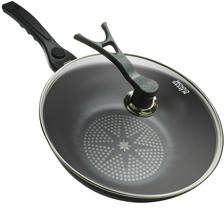

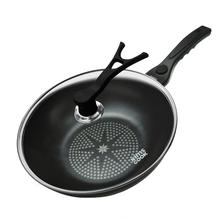

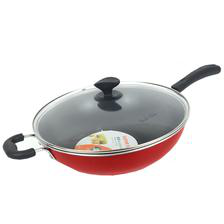

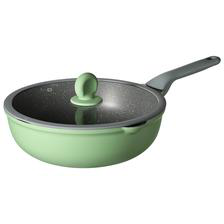

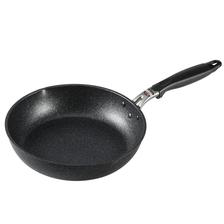

In [48]:
# 查看数据样例
!sed -n "5,5p" ../datapath/datasets/MUGE/valid_texts.jsonl # 验证集第三条样本，对应上面第5行

import lmdb
import base64
from io import BytesIO
from PIL import Image

image_ids = [225106, 139500, 349934, 941660, 515959] # 模型预测的top-5相关图片

lmdb_imgs = "../datapath/datasets/MUGE/lmdb/valid/imgs"
env_imgs = lmdb.open(lmdb_imgs, readonly=True, create=False, lock=False, readahead=False, meminit=False)
txn_imgs = env_imgs.begin(buffers=True)
for image_id in image_ids:
    image_b64 = txn_imgs.get("{}".format(image_id).encode('utf-8')).tobytes()
    img = Image.open(BytesIO(base64.urlsafe_b64decode(image_b64)))
    img.show()

### 3. Recall计算

我们提供了评测脚本计算检索任务的Recall@1/5/10，同时给出mean recall（Recall@1/5/10的平均数）。运行如下命令即可获取分数:

In [49]:
# 根据top-10预测结果，计算验证集的Recall@1/5/10，同时给出mean recall（Recall@1/5/10的平均数）

split="valid" # 指定计算valid或test集特征

run_command = "export PYTHONPATH=${PYTHONPATH}:`pwd`/cn_clip;" + \
f"""
python cn_clip/eval/evaluation.py \
    {DATAPATH}/datasets/{dataset_name}/{split}_texts.jsonl \
    {DATAPATH}/datasets/{dataset_name}/{split}_predictions.jsonl \
    output.json;
cat output.json
"""
print(run_command.lstrip())
!{run_command}

export PYTHONPATH=${PYTHONPATH}:`pwd`/cn_clip;
python cn_clip/eval/evaluation.py     ../datapath//datasets/MUGE/valid_texts.jsonl     ../datapath//datasets/MUGE/valid_predictions.jsonl     output.json;
cat output.json

Read standard from ../datapath//datasets/MUGE/valid_texts.jsonl
Read user submit file from ../datapath//datasets/MUGE/valid_predictions.jsonl
The evaluation finished successfully.
{"success": true, "score": 75.33280085197018, "scoreJson": {"score": 75.33280085197018, "mean_recall": 75.33280085197018, "r1": 56.86900958466453, "r5": 81.21006389776358, "r10": 87.91932907348243}}

可以看到验证集上，我们取得了~75的Mean Recall值，同时也给出了详细的Recall@1/5/10. 这个分数，已经比直接使用同规模预训练ckpt进行预测（zero-shot）的71.1更高，说明我们的finetune让模型更加适配到电商检索任务的领域数据上。通过调节不同的超参，上面finetune的分数还有很大的提升空间。在我们的实验中，Chinese-CLIP各规模zero-shot以及finetune，在验证集上可以得到的分数大体如下（更多Chinese-CLIP在其他任务的实验结果，请详见Github代码库 https://github.com/OFA-Sys/Chinese-CLIP/blob/master/Results.md ）：

**MUGE Text-to-Image Retrieval (Official Validation Set)**:
<table border="1" width="100%">
    <tr align="center">
        <th>Setup</th><th colspan="4">Zero-shot</th><th colspan="4">Finetune</th>
    </tr>
    <tr align="center">
        <td>Metric</td><td>R@1</td><td>R@5</td><td>R@10</td><td>MR</td><td>R@1</td><td>R@5</td><td>R@10</td><td>MR</td>
    </tr>
	<tr align="center">
        <td>CN-CLIP<sub>RN50</sub></td><td>42.6</td><td>68.6</td><td>77.9</td><td>63.0</td><td>48.6</td><td>75.1</td><td>84.0</td><td>69.2</td>
    </tr>  
	<tr align="center">
        <td>CN-CLIP<sub>ViT-B/16</sub></td><td>52.1</td><td>76.7</td><td>84.4</td><td>71.1</td><td>58.4</td><td>83.6</td><td>90.0</td><td>77.4</td>
    </tr>
	<tr align="center">
        <td>CN-CLIP<sub>ViT-L/14</sub></td><td>56.3</td><td>79.8</td><td>86.2</td><td>74.1</td><td>63.3</td><td>85.6</td><td>91.3</td><td>80.1</td>
    </tr>  
	<tr align="center">
        <td>CN-CLIP<sub>ViT-L/14@336px</sub></td><td>59.0</td><td>81.4</td><td>87.8</td><td>76.1</td><td>65.3</td><td>86.7</td><td>92.1</td><td>81.3</td>
    </tr>    
	<tr align="center">
        <td>CN-CLIP<sub>ViT-H/14</sub></td><td><b>63.0</b></td><td><b>84.1</b></td><td><b>89.2</b></td><td><b>78.8</b></td><td><b>68.9</b></td><td><b>88.7</b></td><td><b>93.1</b></td><td><b>83.6</b></td>
    </tr>    
</table>
<br>

## 准备测试集结果

下面我们在测试集上，再运行一次和验证集同样的特征计算和KNN召回流程，只是数据换成测试集，从而准备一份测试集预测结果，用于提交官方

In [50]:
# 为测试集图片池和query文本计算特征
dataset_name="MUGE"
split="test" # 指定计算valid或test集特征
resume=f"{DATAPATH}/experiments/muge_finetune_vit-b-16_roberta-base_bs48_1gpu/checkpoints/epoch_latest.pt"

run_command = "export PYTHONPATH=${PYTHONPATH}:`pwd`/cn_clip;" + \
f"""
python -u cn_clip/eval/extract_features.py \
    --extract-image-feats \
    --extract-text-feats \
    --image-data="{DATAPATH}/datasets/{dataset_name}/lmdb/{split}/imgs" \
    --text-data="{DATAPATH}/datasets/{dataset_name}/{split}_texts.jsonl" \
    --img-batch-size=32 \
    --text-batch-size=32 \
    --context-length=52 \
    --resume={resume} \
    --vision-model=ViT-B-16 \
    --text-model=RoBERTa-wwm-ext-base-chinese
"""
print(run_command.lstrip())
!{run_command}

export PYTHONPATH=${PYTHONPATH}:`pwd`/cn_clip;
python -u cn_clip/eval/extract_features.py     --extract-image-feats     --extract-text-feats     --image-data="../datapath//datasets/MUGE/lmdb/test/imgs"     --text-data="../datapath//datasets/MUGE/test_texts.jsonl"     --img-batch-size=32     --text-batch-size=32     --context-length=52     --resume=../datapath//experiments/muge_finetune_vit-b-16_roberta-base_bs48_1gpu/checkpoints/epoch_latest.pt     --vision-model=ViT-B-16     --text-model=RoBERTa-wwm-ext-base-chinese

/home/pai/lib/python3.6/site-packages/OpenSSL/crypto.py:12: CryptographyDeprecationWarning: Python 3.6 is no longer supported by the Python core team. Therefore, support for it is deprecated in cryptography and will be removed in a future release.
  from cryptography import x509
Params:
  context_length: 52
  debug: False
  extract_image_feats: True
  extract_text_feats: True
  image_data: ../datapath//datasets/MUGE/lmdb/test/imgs
  image_feat_output_path: None
  img_batc

In [51]:
# 进行KNN检索，为测试集每个query，匹配特征余弦相似度最高的top-10商品图片

split="test" # 指定计算valid或test集特征

run_command = "export PYTHONPATH=${PYTHONPATH}:`pwd`/cn_clip;" + \
f"""
python -u cn_clip/eval/make_topk_predictions.py \
    --image-feats="{DATAPATH}/datasets/{dataset_name}/{split}_imgs.img_feat.jsonl" \
    --text-feats="{DATAPATH}/datasets/{dataset_name}/{split}_texts.txt_feat.jsonl" \
    --top-k=10 \
    --eval-batch-size=32768 \
    --output="{DATAPATH}/datasets/{dataset_name}/{split}_predictions.jsonl"
"""
print(run_command.lstrip())
!{run_command}

export PYTHONPATH=${PYTHONPATH}:`pwd`/cn_clip;
python -u cn_clip/eval/make_topk_predictions.py     --image-feats="../datapath//datasets/MUGE/test_imgs.img_feat.jsonl"     --text-feats="../datapath//datasets/MUGE/test_texts.txt_feat.jsonl"     --top-k=10     --eval-batch-size=32768     --output="../datapath//datasets/MUGE/test_predictions.jsonl"

Params:
  eval_batch_size: 32768
  image_feats: ../datapath//datasets/MUGE/test_imgs.img_feat.jsonl
  output: ../datapath//datasets/MUGE/test_predictions.jsonl
  text_feats: ../datapath//datasets/MUGE/test_texts.txt_feat.jsonl
  top_k: 10
Begin to load image features...
30399it [00:07, 4257.35it/s]
Finished loading image features.
Begin to compute top-10 predictions for texts...
5004it [02:40, 31.19it/s]
Top-10 predictions are saved in ../datapath//datasets/MUGE/test_predictions.jsonl
Done!


In [52]:
!head -n 5 ../datapath/datasets/MUGE/test_predictions.jsonl

{"text_id": 342160, "image_ids": [599057, 224560, 282239, 908966, 155774, 511583, 368883, 611578, 808493, 598944]}
{"text_id": 342169, "image_ids": [686662, 191142, 344670, 1122644, 986797, 406083, 969455, 424464, 2971, 251105]}
{"text_id": 342177, "image_ids": [75011, 173661, 108900, 454071, 814416, 1114918, 331928, 474673, 98571, 1069979]}
{"text_id": 342198, "image_ids": [526032, 277415, 1015004, 443782, 612288, 862027, 944337, 780085, 1122730, 442797]}
{"text_id": 342202, "image_ids": [258830, 270450, 426942, 807698, 529722, 465381, 777309, 937790, 650457, 23176]}


该结果下载并提交到天池后，预期将取得56.5/80.6/87.5左右的Recall@1/5/10，即74.9左右的Mean Recall，可能由于finetune的随机性有一些小幅度的浮动

以上就是我们使用Chinese-CLIP，完成电商图文检索挑战赛的一个完整的baseline流程，欢迎大家在此基础上进一步提升效果。也希望大家多多支持Chinese-CLIP，如果觉得有帮助请为我们的 **[Github repo](https://github.com/OFA-Sys/Chinese-CLIP)** 点点star⭐️，多提宝贵的意见！